In [288]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from numpy import linalg as LA

In [304]:
def generate_data(means, variances, scale, sample_size):
    dataset = np.zeros((len(means)*sample_size, 3))
    for j in range(len(means)):
        # [x1, y1] = np.random.multivariate_normal(scale*mu,sigma, (1,sample_size)).T
        data = np.random.multivariate_normal(means[j],scale*variances[j], (1,sample_size)).T
        x, y, z = data[0,:,0], data[1,:,0], np.array([j]*sample_size)
        dataset[j*sample_size:(j+1)*sample_size,:] = np.vstack((x,y,z)).T
    return dataset

In [290]:
def match_labels(KmCC, orig_clus):
    # KmCC stands for KmeansClusterCenters, orig_clus stands for OriginalClusters
    new_cluster_labels = []
    for clus in orig_clus:
        diff = []
        for new_clus in KmCC:
            array1 = new_clus - clus
            diff.append(np.abs(array1[0]) + np.abs(array1[1]))
        new_cluster_labels.append(diff.index(min(diff)))
    return new_cluster_labels

In [291]:
def accuracy(km_cc, orig_cc, kml):
    # km_cc = kmeans.cluster_centers_ , orig_cc = [mu_a,mu_b,mu_c], kml = kmeans.labels_
    NCL = match_labels(km_cc, orig_cc)
    PredictedLabels = [NCL[0]]*100 + [NCL[1]]*100 + [NCL[2]]*100
    correct_count = 0
    for i in range(300):
        if PredictedLabels[i] == kml[i]:
            correct_count += 1
    return (correct_count)/300

In [292]:
def objective(km_cc, kml, data):
    Objective = 0
    for i in range(300):
        Objective = Objective + (LA.norm( data[i] - km_cc[kml[i]] ))**2

    return Objective

In [309]:
mu_list = [np.array([-1.,-1.]), np.array([1.,-1.]), np.array([0.,1.])]
sigma_list = [np.array([[2.,0.5],[0.5,1.]]), np.array([[1.,-0.5],[-0.5,2.]]), np.array([[1.,0.],[0.,2.]])]
sigmas = [0.5,1,2,4,8]
km_objs = []
km_accs = []
gm_objs = []
gm_accs = []

for sigma in sigmas:

    # generate data
    data = generate_data(mu_list, sigma_list, sigma, 100)
    train_data = data[:,0:2]
    train_labels = data[:,2:3].astype(int)[:,0]


    km = KMeans(n_clusters=3, n_init="auto").fit(train_data)
    km_acc = accuracy(km.cluster_centers_, mu_list, km.labels_)
    km_accs.append(km_acc)
    km_obj = objective(km.cluster_centers_, km.labels_, train_data)
    km_objs.append(km_obj)


    gm = GaussianMixture(n_components=3).fit(train_data)
    gm_acc = accuracy(gm.means_,mu_list, gm.predict(train_data))
    gm_accs.append(gm_acc)
    gm_obj = objective(gm.means_, gm.predict(train_data), train_data)
    gm_objs.append(gm_obj)

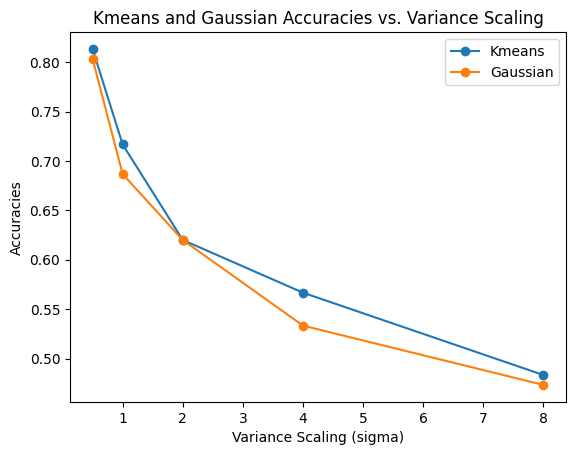

In [310]:
plt.plot(sigmas, km_accs, marker = 'o', label='Kmeans')
plt.plot(sigmas, gm_accs, marker = 'o', label = 'Gaussian')
plt.title('Kmeans and Gaussian Accuracies vs. Variance Scaling')
plt.xlabel('Variance Scaling (sigma)')
plt.ylabel('Accuracies')
plt.legend()
plt.savefig('KmeansGaussianAccuracies.pdf')

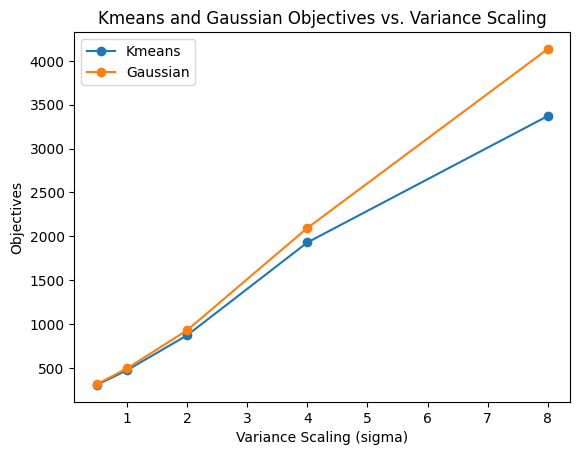

In [311]:
plt.plot(sigmas, km_objs, marker = 'o', label = 'Kmeans')
plt.plot(sigmas, gm_objs, marker = 'o', label = 'Gaussian')
plt.title('Kmeans and Gaussian Objectives vs. Variance Scaling')
plt.xlabel('Variance Scaling (sigma)')
plt.ylabel('Objectives')
plt.legend()
plt.savefig("KmeansGaussianObjectives.pdf")